In [1]:
import qrcode

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
from datetime import datetime

import os

import tkinter as tk
from tkinter import filedialog as fd

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

import collections

In [4]:
import sys
# IMPORTACIONES
sys.path.append('..')
from config import API_AMIGOCLOUD_TOKEN_ADM
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

In [5]:
RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [6]:
RUTA_COMPLETA

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

## Leer catastro

In [7]:
cat_filename = r'G:\OneDrive - Ingenio Azucarero Guabira S.A\INFORMACION GENERAL\CATASTRO\NUEVO\CATASTRO.shp'
#cat_filename = 'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\INFORMACION GENERAL\\CATASTRO\\NUEVO\\catastro140624.shp'
cat_filename

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\INFORMACION GENERAL\\CATASTRO\\NUEVO\\CATASTRO.shp'

In [8]:
# leer el .shp seleccionado
data_catastro = gpd.read_file(cat_filename)

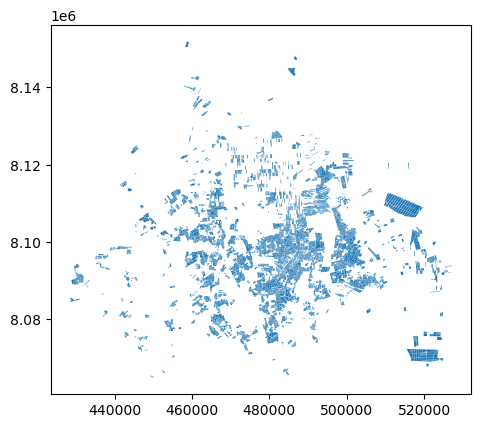

In [9]:
data_catastro.plot()
plt.show()

In [10]:
data_catastro.head(3)

,idd,id,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,variedad,soca,zona,...,fc,codco,coducaf,zafra,seguimient,estado,fci,tipoc,lote_admin,geometry
0,5892,000014160000L2,1416.0,COMUNIDAD FJA P51--VALE NEMECIO,14703.0,VALE MORA NEMECIO,L2,RBB7726,8.0,None,...,2024-07-17,NaN,206.0,2025.0,si,None,0.0,None,None,"POLYGON ((482655.759 8119042.564, 482655.412 8..."
1,6,00005580000L1,558.0,NARANJAL--AGUILERA MARTA S,4834.0,GUTIERREZ MARTHA S. AGUILERA DE,L1,RENOVACION,123.0,50,...,2024-07-17,196.0,286.0,2025.0,None,None,0.0,None,None,"POLYGON ((479298.237 8076112.129, 479308.317 8..."
2,10232,000014160000L4,1416.0,COMUNIDAD FJA P51--VALE NEMECIO,14703.0,VALE MORA NEMECIO,L4,RBB7726,8.0,None,...,2024-07-17,NaN,206.0,2025.0,si,None,0.0,None,None,"POLYGON ((482598.920 8118882.179, 482587.954 8..."


## Leer data de codigos de cosecha

In [11]:
codcos_filename = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\DATA\\GRUPO_COSECHA.xlsx'
codcos_filename

'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - AVANCE COSECHA\\2025\\DATA\\\\GRUPO_COSECHA.xlsx'

In [12]:
data_cod_cosecha = pd.read_excel(codcos_filename, sheet_name='2025')

In [13]:
data_cod_cosecha.head()

,CODIGO CAÑERO,NOMBRE CAÑERO,GRUPO DE COSECHA,INS,DELEGADO,GRUPO COSECHA,Columna1,Columna2
0,515,AGUILERA OLGA RIVERO VDA DE,1,50,DELEGADO,1.0,AGUILERA OLGA RIVERO VDA DE,SI
1,790,AGUILERA RIVERO JESSICA BEATRIZ,1,69,NaN,1.0,AGUILERA RIVERO JESSICA BEATRIZ,SI
2,40004,AGUILERA RIVERO NICOLAS JULIO,1,50,NaN,1.0,AGUILERA RIVERO NICOLAS JULIO,SI
3,1215,AGUILERA RIVERO OLGA KARINA,1,50,NaN,1.0,AGUILERA RIVERO OLGA KARINA,SI
4,8003,AGUILERA RIVERO SERGIO STEFAN,1,50,NaN,1.0,AGUILERA RIVERO SERGIO STEFAN,SI


## Leer codigos de grupo

In [15]:
cod_cos = 414
# lista de propiedades de grupo cañerp
propiedades = [674]

In [16]:
grupo = data_cod_cosecha[data_cod_cosecha['GRUPO DE COSECHA']==cod_cos]

In [17]:
grupo

,CODIGO CAÑERO,NOMBRE CAÑERO,GRUPO DE COSECHA,INS,DELEGADO,GRUPO COSECHA,Columna1,Columna2
1061,41973,RIBERA JUSTINIANO JEFFER PAUL,414,50,DELEGADO,414.0,RIBERA JUSTINIANO JEFFER PAUL,SI


In [18]:
delegado = grupo[grupo['DELEGADO'] == 'DELEGADO']
if (len(delegado) == 1):
    cod_ca_delegado = delegado.iloc[0]['CODIGO CAÑERO']
    nom_ca_delegado = delegado.iloc[0]['NOMBRE CAÑERO']
else:
    print('Error al seleccionar delegado')

In [19]:
cods_ca = list(grupo['CODIGO CAÑERO'])
cods_ca

[41973]

In [20]:
cods_ca

[41973]

In [21]:
lista_ca = []
for i in cods_ca:
    cod_ca = data_cod_cosecha[data_cod_cosecha['CODIGO CAÑERO'] == i].iloc[0]['CODIGO CAÑERO']
    nom_ca = data_cod_cosecha[data_cod_cosecha['CODIGO CAÑERO'] == i].iloc[0]['NOMBRE CAÑERO']
    dict_ca = { 'cod_ca' : cod_ca, 'nom_ca' : nom_ca }
    lista_ca.append(collections.namedtuple("canhero", dict_ca.keys())(*dict_ca.values()))
lista_ca

[canhero(cod_ca=41973, nom_ca='RIBERA JUSTINIANO JEFFER PAUL ')]

In [22]:
def crear_cite(cod_canhero, nom_canhero, tipo_reporte):
    ruta_api_google = RUTA_COMPLETA + '\_keys\client_secret_google_sheets.json'
    # Configura las credenciales
    scope = ["https://spreadsheets.google.com/feeds",
             'https://www.googleapis.com/auth/spreadsheets', 
             "https://www.googleapis.com/auth/drive.file", 
             "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(ruta_api_google, scope)
    client = gspread.authorize(creds)
    # Abre la hoja de cálculo con ID y la hoja específica
    spreadsheet = client.open_by_key("1Wbmmjy9s8JdXKP8qM_eA_OrCV--F1UZLnzQJ--ASOFI")
    sheet = spreadsheet.sheet1
    # Lee los datos
    data_sheet = sheet.get_all_records()
    df = pd.DataFrame(data_sheet)
    # Encuentra el número más grande y lo incrementamos y agrega un nuevo registro
    max_value = df['No'].max()
    no = int(max_value + 1)
    # llenamos los demas campos
    fecha = datetime.now().strftime("%m/%d/%Y")
    cod_ca = int(cod_canhero)
    nom_ca = nom_canhero
    tipo = tipo_reporte
    #agregar el registro
    sheet.append_row([no, fecha, cod_ca, nom_ca, tipo])
    return no

In [23]:
cite = crear_cite(cod_ca_delegado, nom_ca_delegado, 'INB')
cite

383

In [24]:
# crear diccionario con datos de cañeros y propiedades
fecha = datetime.now()
fecha = fecha.strftime("%d/%m/%Y")
datos_ca = { 'fecha' : fecha, 'cite': cite, 'ca' : lista_ca }

In [25]:
data = collections.namedtuple("insp", datos_ca.keys())(*datos_ca.values())
data

insp(fecha='24/10/2025', cite=383, ca=[canhero(cod_ca=41973, nom_ca='RIBERA JUSTINIANO JEFFER PAUL ')])

In [26]:
#QR
# Datos que quieres que contenga el QR
texto = '''
--UTEA--
--DATOS CATASTRALES--

Codigo informe: {cod_inf}
Fecha de emición: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Tipo de informe: {tipo}'''\
.format(
    cod_inf=str(data.cite) + '-' + data.fecha[6:], 
    fecha=data.fecha, 
    canero=nom_ca_delegado,
    cod_ca=cod_ca_delegado,
    tipo='Informe para Banco')
# Generar el código QR
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(texto)
qr.make(fit=True)
img = qr.make_image(fill_color="black", back_color="white")

filename_qr = 'qr_' + str(cod_ca_delegado) + '_' + data.fecha.replace('/', '-')
ruta_qr = RUTA_COMPLETA + '/planos/' + filename_qr + '.png'
#Guardar el código QR en un archivo
img.save(ruta_qr)

In [27]:
ruta_qr

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON/planos/qr_41973_24-10-2025.png'

In [28]:
cods_ca

[41973]

In [29]:
propiedades

[674]

In [30]:
catastro = data_catastro[data_catastro['unidad_03'].isin(cods_ca)]

In [31]:
total_hoja = 0
total_soca = 0
total_renov = 0
total_produc = 0
total_cultivado = 0
props_obj = []
for i in propiedades:
    propiedad = catastro[catastro['unidad_01']==i]
    cod_prop = propiedad.iloc[0]['unidad_01']
    nom_prop = propiedad.iloc[0]['unidad_02'].replace('_', ' ').split('--')[0]
    hoja = propiedad[propiedad['soca']==0]['area'].sum()
    soca = propiedad[(propiedad['soca']!=0) & (propiedad['variedad']!='RENOVACION')]['area'].sum()
    renov = propiedad[propiedad['variedad']=='RENOVACION']['area'].sum()
    produc = hoja + soca
    cultivado = hoja + soca + renov
    
    total_hoja += hoja
    total_soca += soca
    total_renov += renov
    total_produc += produc
    total_cultivado += cultivado
    
    # seleccionar las columnas
    prop_data = propiedad[['unidad_05', 'area', 'variedad', 'fs', 'soca']]
    # cambiar nombre de comlumnas
    prop_table = prop_data.rename(columns={'unidad_05':'lote', 'area':'area', 'variedad':'variedad', 'fs':'fs', 'soca':'corte'})
    # truncar a dos decimales
    prop_table['area'] = prop_table['area'].round(decimals=2)
    # formato de fecha
    prop_table['fs'] = pd.to_datetime(prop_table['fs']).dt.strftime('%d/%m/%Y')
    
    lista_lotes = []
    for i in range(len(prop_table)):
        lote = prop_table.iloc[i].to_dict()
        if(lote['variedad'] == 'RENOVACION'):
            lote['fs'] = ''
            lote['corte'] = ''
        lote = collections.namedtuple("lote", lote.keys())(*lote.values())
        lista_lotes.append(lote)
    
    propiedad_dict = { 
        'cod_prop' : cod_prop,
        'nom_prop' : nom_prop,
        'hoja' : hoja, 
        'soca' : soca, 
        'renov' : renov,
        'produc' : produc,
        'cultivado' : cultivado,
        'lotes' : lista_lotes}
    props_obj.append(collections.namedtuple("propiedad", propiedad_dict.keys())(*propiedad_dict.values()))

In [32]:
totales = { 
    't_hoja': total_hoja,
    't_soca' : total_soca,
    't_renov' : total_renov,
    't_produc': total_produc,
    't_cultivado' : total_cultivado}

In [33]:
total = collections.namedtuple("total", totales.keys())(*totales.values())

In [34]:
doc = DocxTemplate(RUTA_COMPLETA+"/templates/tpl_informe_banco.docx")
in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
context = {'insp' : data, 'propiedades' : props_obj, 'total' : total, 'qr':in_line_qr}
doc.render(context)
file_name = str(cod_ca_delegado) + '_INB_' + data.fecha.replace('/', '-') + '_' + nom_ca_delegado
doc.save(RUTA_COMPLETA + '/informes/_' + file_name + '.docx')